In [1]:
# -*- coding: utf-8 -*-
import warnings
import os.path
import sys
import pickle
import datetime
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso, Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import make_pipeline
import ow_f01, cxmn_train, cxmn_predict, predict_mean
from code.refactor.common import loadSettingsFromYamlFile, save_object, object2Float, get_column_by_type

warnings.filterwarnings("ignore", category=DeprecationWarning)

/home/ubuntu/lijingjie/ljj/local/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
pd.options.display.max_columns=999
pd.options.display.max_rows=999

In [3]:
p1_used_header = ['productkey', 'promotionkey', 'startdatetime', 'enddatetime', 'jdprice', 'syntheticgrossprice', 'promotiondesc', 'promotiondesc_flag', 'promotiontype', 'promotionsubtype',
                'areatypearray', 'tokenflag', 'directdiscount_discount', 'directdiscount_availabilitynumber', 'bundle_subtype1_threshold', 'bundle_subtype1_giveaway',
                'bundle_subtype4_threshold1', 'bundle_subtype4_giveaway1', 'bundle_subtype4_threshold2', 'bundle_subtype4_giveaway2', 'bundle_subtype4_threshold3',
                'bundle_subtype4_giveaway3', 'bundle_subtype2_threshold', 'bundle_subtype2_giveaway', 'bundle_subtype2_maximumgiveaway', 'bundle_subtype15_thresholdnumber1',
                'bundle_subtype15_giveawayrate1', 'bundle_subtype15_thresholdnumber2', 'bundle_subtype15_giveawayrate2', 'bundle_subtype15_thresholdnumber3',
                'bundle_subtype15_giveawayrate3', 'bundle_subtype6_thresholdnumber', 'bundle_subtype6_freenumber', 'suit_maxvaluepool', 'suit_minvaluepool', 'suit_avgvaluepool',
                'suit_discount', 'directdiscount_saleprice', 'bundle_subtype1_percent', 'bundle_subtype4_percent', 'bundle_subtype2_percent', 'bundle_subtype15_percent',
                'bundle_subtype6_percent', 'suit_percent', 'allpercentdiscount', 'mainproductkey', 'hierarchylevel3key', 'createdate', 'statuscode', 'dt']
p2_used_header = ['ProductKey', 'Date', 'HierarchyLevel3Key', 'PromotionCount', 'bundlecount', 'MaxDiscount', 'MinDiscount', 'AvgDiscount', 'MaxSyntheticDiscountA',
				         'MinSyntheticDiscountA', 'AvgSyntheticDiscountA', 'MaxBundleDiscount', 'MinBundleDiscount', 'AvgBundleDiscount', 'MaxDirectDiscount', 'MinDirectDiscount',
				         'AvgDirectDiscount', 'MaxFreegiftDiscount', 'MinFreegiftDiscount', 'AvgFreegiftDiscount', 'SyntheticGrossPrice', 'promotionkey', 'promotiontype',
				         'promotionsubtype', 'syntheticgrossprice_vb', 'jdprice', 'syntheticdiscounta_vb', 'durationinhours', 'daynumberinpromotion', 'bundleflag', 'directdiscountflag',
				         'freegiftflag', 'suitflag', 'numberproducts', 'numberhierarchylevel1', 'numberhierarchylevel2', 'numberhierarchylevel3', 'strongmark', 'stockprice', 'dt']
suffix = '.da'
item = 'p1'
for_what = ['train', 'predict']

In [4]:
def statitics_mape(new_df_final):
		new_df_sku = new_df_final.groupby('ProductKey').sum().reset_index()
		print "ensemble pred sum : %f"%(new_df_sku.ypred_mean_promo_new.sum())
		print "raw pred sum :      %f"%(new_df_sku.ypred_raw.sum())
		print "actual sum:         %f"%(new_df_sku.salesForecast.sum())

		print "raw pred residual:      %f"%(np.sum(np.abs(new_df_sku.ypred_raw - new_df_sku.salesForecast)))
		print "ensemble pred residual: %f"%(np.sum(np.abs(new_df_sku.ypred_mean_promo_new - new_df_sku.salesForecast)))

		print "raw pred mape: %f"%(np.sum(np.abs(new_df_sku.ypred_raw - new_df_sku.salesForecast)) / new_df_sku.salesForecast.sum())
		print "ensemble mape: %f"%(np.sum(np.abs(new_df_sku.ypred_mean_promo_new - new_df_sku.salesForecast)) / new_df_sku.salesForecast.sum())

In [5]:
def get_online_history_data():
    # p1 = pd.read_csv('/home/ubuntu/sunjiadong/promotion_offline/tmp/data/shishang/12029/12029_p1.da',sep='\t',header=None)
    # p2 = pd.read_csv('/home/ubuntu/sunjiadong/promotion_offline/tmp/data/shishang/12029/12029_p2.da',sep='\t',header=None)
    # ts = pd.read_csv('/home/ubuntu/sunjiadong/promotion_offline/tmp/data/shishang/12029/12029_ts.da',sep='\t',header=None)
    # p1 = pd.read_csv('/home/ubuntu/sunjiadong/promotion_offline/tmp/data/7054_p1.da', sep='\t', header=None)
    # p2 = pd.read_csv('/home/ubuntu/sunjiadong/promotion_offline/tmp/data/7054_p2.da', sep='\t', header=None)
    # ts = pd.read_csv('/home/ubuntu/sunjiadong/promotion_offline/tmp/data/7054_ts.da', sep='\t', header=None)
    p1 = pd.read_csv('/home/ubuntu/sunjiadong/promotion_offline/tmp/data/736_p1.da', sep='\t', header=None)
    p2 = pd.read_csv('/home/ubuntu/sunjiadong/promotion_offline/tmp/data/736_p2.da', sep='\t', header=None)
    ts = pd.read_csv('/home/ubuntu/sunjiadong/promotion_offline/tmp/data/736_ts.da', sep='\t', header=None)
    return p1,p2,ts


In [6]:
scenarioSettingsPath = 'code/refactor/ow_scenario.yaml'
scenario = loadSettingsFromYamlFile(scenarioSettingsPath)
area_rdc_map = pd.read_csv('/home/ubuntu/yulong/promotion_offline/tmp/ow_deploy_single/area_rdc_mapping.csv')
holidays_df=pd.read_csv('/home/ubuntu/yulong/promotion_offline/tmp/ow_deploy_single/holidays.csv')
seasonality_df = pd.read_csv('tmp/data/870_season.csv', parse_dates=['Date'])

In [7]:
cate = 736
pred_date = pd.to_datetime('2018-05-08')
scenario['lookforwardPeriodDays'] = 90

# cate = 7054
# pred_date = pd.to_datetime('2018-02-01')
# scenario['lookforwardPeriodDays'] = 10

# cate = 12029
# pred_date = pd.to_datetime('2018-05-07')
# scenario['lookforwardPeriodDays'] = 7


In [8]:
p1_df,p2_df,ts_df = get_online_history_data()

In [9]:
p1_df.columns = p1_used_header
p2_df.columns = p2_used_header


In [10]:
ts_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,2018-07-28,0,3,1204417,670,729,736,16981,0.0,0.0,0.0,1.0,1.0,0.0,0.0,4.0,0.0
1,2018-07-27,1,3,1204417,670,729,736,16981,0.0,0.0,0.0,1.0,1.0,0.0,0.0,4.0,0.0
2,2018-07-26,2,3,1204417,670,729,736,16981,0.0,0.0,0.0,1.0,1.0,0.0,0.0,4.0,0.0
3,2018-07-25,3,3,1204417,670,729,736,16981,0.0,0.0,0.0,1.0,1.0,0.0,0.0,4.0,0.0
4,2018-07-24,4,3,1204417,670,729,736,16981,0.0,0.0,0.0,1.0,1.0,0.0,0.0,4.0,0.0


In [11]:
print p2_df.Date.min()
print p2_df.Date.max()

2015-01-01
2018-07-27


In [12]:
###handle p2
p2_df['Date'] = pd.to_datetime(p2_df['Date'])
p2_df['dt'] = pd.to_datetime(p2_df['dt'])
p2_df.replace('null', np.nan, inplace=True)
p2_df.replace('None', np.nan, inplace=True)
p2_df.replace(-999, np.nan, inplace=True)
p2_df.drop_duplicates(inplace=True)

# Convert Object -> float
if 'object' in p2_df.dtypes.values:
    obj_cols = get_column_by_type(p2_df,'object')
    object2Float(p2_df,obj_cols)


convert to Float columns:
MaxSyntheticDiscountA
convert to Float columns:
MinSyntheticDiscountA
convert to Float columns:
AvgSyntheticDiscountA
convert to Float columns:
SyntheticGrossPrice
convert to Float columns:
promotionkey
convert to Float columns:
promotiontype
convert to Float columns:
promotionsubtype
convert to Float columns:
syntheticgrossprice_vb
convert to Float columns:
jdprice
convert to Float columns:
syntheticdiscounta_vb
convert to Float columns:
durationinhours
convert to Float columns:
daynumberinpromotion
convert to Float columns:
bundleflag
convert to Float columns:
directdiscountflag
convert to Float columns:
freegiftflag
convert to Float columns:
suitflag
convert to Float columns:
stockprice


In [13]:
def handle_f01(p1_df, for_what, area_rdc_map, pred_date, scenario):
    for fw in for_what:
    	print "output and save: %s_p1_%s"%(str(cate),fw)
    	train_pred_gate = fw   # 'train'
    	f01_output = ow_f01.generate_f01_promo(area_rdc_map, p1_df, scenario, train_pred_gate, ForecastStartDate=pred_date)
    	if train_pred_gate == 'train':
    		train_p1_df = f01_output
    	else:
    		predict_p1_df = f01_output
    return train_p1_df, predict_p1_df
train_p1_df,predict_p1_df = handle_f01(p1_df, for_what, area_rdc_map, pred_date, scenario)


output and save: 736_p1_train
convert to Float columns:
allpercentdiscount
convert to Float columns:
bundle_subtype15_giveawayrate1
convert to Float columns:
bundle_subtype15_giveawayrate2
convert to Float columns:
bundle_subtype15_giveawayrate3
convert to Float columns:
bundle_subtype15_percent
convert to Float columns:
bundle_subtype15_thresholdnumber1
convert to Float columns:
bundle_subtype15_thresholdnumber2
convert to Float columns:
bundle_subtype15_thresholdnumber3
convert to Float columns:
bundle_subtype1_giveaway
convert to Float columns:
bundle_subtype1_percent
convert to Float columns:
bundle_subtype1_threshold
convert to Float columns:
bundle_subtype2_giveaway
convert to Float columns:
bundle_subtype2_maximumgiveaway
convert to Float columns:
bundle_subtype2_percent
convert to Float columns:
bundle_subtype2_threshold
convert to Float columns:
bundle_subtype4_giveaway1
convert to Float columns:
bundle_subtype4_giveaway2
convert to Float columns:
bundle_subtype4_giveaway3
con

/home/ubuntu/lijingjie/ljj/local/lib/python2.7/site-packages/pandas/core/frame.py:3027: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
code/refactor/common.py:2111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  period_promo_raw['rdc_list'] = period_promo_raw['areatypearray'].apply(lambda x: extract_rdc(x, area_rdc_dict))
/home/ubuntu/lijingjie/ljj/local/lib/python2.7/site-packages/pandas/core/generic.py:4355: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.

('| - Before filter: ', 116468)
('| - Filtered tokens: ', 115702)
('| - Filtered descriptions: ', 115022)
('| - Filtered flash sale available units', 115005)
('| - Filtered non-national promo: ', 115005)
| | - Add additional columns
| | - Calculate dd price per promotion
| | - Calculate dd price per period
| | - Generate bundle features
| | - Calculate bundle price per period
| - Reformat date
| | - process features
| | - aggregate features per period
| | - prep data for Step 3
| | - fix indicators on days with end time 00:00 or start time 23:59
| | - calculate weighted price per day
| | - aggregate features per day
f01 shape
(819698, 23)
output and save: 736_p1_predict
('| - Before filter: ', 44575)
('| - Filtered tokens: ', 44270)
('| - Filtered descriptions: ', 43235)
('| - Filtered flash sale available units', 43232)
('| - Filtered non-national promo: ', 43232)
| | - Add additional columns
| | - Calculate dd price per promotion
| | - Calculate dd price per period
| | - Generate bun

In [14]:
print train_p1_df.shape
print predict_p1_df.shape

(819698, 23)
(371338, 23)


In [15]:
ts_df.columns = ['Date', 'ind', 'RDCKey', 'ProductKey', 'HierarchyLevel1Key', 'HierarchyLevel2Key', 'HierarchyLevel3Key', 'brand_code', 'sales', 'priceAfterDiscount', 'jd_prc', 'vendibility', 'counterState', 'salesForecast', 'reserveState', 'stockQuantity', 'utc_flag']
ts_df['Date'] = pd.to_datetime(ts_df['Date'])

ts_df.replace('null', np.nan, inplace=True)
ts_df.replace(-999, np.nan, inplace=True)
ts_df.replace('None', np.nan, inplace=True)
ts_to_float_col = ['RDCKey', 'ProductKey', 'HierarchyLevel1Key', 'HierarchyLevel2Key', 'HierarchyLevel3Key', 'brand_code', 'sales', 'priceAfterDiscount', 'jd_prc', 'vendibility', 'counterState', 'salesForecast', 'reserveState', 'stockQuantity', 'utc_flag']
if 'object' in ts_df[ts_to_float_col].dtypes.values:
    object2Float(ts_df,ts_to_float_col)


levels = ['HierarchyLevel3Key','ProductKey','RDCKey','Date']
ts_df.sort_values(levels, ascending=[True]*len(levels), inplace=True)
ts_df= ts_df.reset_index(drop=True)

In [16]:
ts_df_bak = ts_df.copy()

In [17]:
print ts_df.Date.min()
print ts_df.Date.max()

2015-04-18 00:00:00
2018-07-28 00:00:00


In [18]:
# -*- coding: utf-8 -*-
import warnings
import os.path
from code.refactor.common import (get_setting_from_cfg, get_setting_path, filter_df_by_cate_id,get_future_sales_feature,\
                                  dummy_features, model_predict, get_weekly_df,get_future_condition_sales_feature,gen_train_valid_by_date,\
                                  generate_promotion_future, get_hour, save_object, add_pv,get_lowest_n,generate_cv_train_valid_set,\
                                  generate_default_values_by_dic,fill_col_with_default, week2month,trans_band_to_int,get_future_condition_sales_feature_stage2,\
                                  loadSettingsFromYamlFile,createSeasonalityFeatures,createLevel3Features,createSeasonalityDecomposeFeatures,\
                                 calculateNationalRolling,calculateRolling,calculateLagging,createDateFeatures,splitTimeWindow,calculateSimilarRolling,calculateStockFeatures,\
                                 process_rdc,clean_data,add_cols,get_dd_price,agg_dd_price,get_bundle_feat,agg_bd_price,process_feature,\
                                 agg_feature,prep_data,calc_weighted_price,agg_feature_day,get_column_by_type,object2Float,object2Int)
from code.refactor.fdc_flow import  filter_non_price_fill_it
import pandas as pd
import xgboost as xgb
import numpy as np
import datetime
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [19]:
ForecastStartDate = pd.to_datetime(pred_date)

In [20]:
DataStartDate = ForecastStartDate - datetime.timedelta(days=scenario['lookbackPeriodDays'])

In [21]:
holidays_df['Date'] = pd.to_datetime(holidays_df['Date'])
object2Int(holidays_df,['Holiday','Ind_1111_pre','Ind_1111','Ind_1111_post','Ind_618_pre','Ind_618','Ind_618_post','Ind_1212'])
for col in area_rdc_map.columns:
    area_rdc_map[col] = area_rdc_map[col].astype('int')
period_promo_raw = train_p1_df
promoCalendarDf = p2_df

convert to Int columns:
Holiday
convert to Int columns:
Ind_1111_pre
convert to Int columns:
Ind_1111
convert to Int columns:
Ind_1111_post
convert to Int columns:
Ind_618_pre
convert to Int columns:
Ind_618
convert to Int columns:
Ind_618_post
convert to Int columns:
Ind_1212


In [22]:
promoCalendarDf = promoCalendarDf[(promoCalendarDf['Date']<ForecastStartDate)&(promoCalendarDf['Date']>DataStartDate)]

ts_df_pred = ts_df[(ts_df['Date']<ForecastStartDate)&(ts_df['Date']>DataStartDate)]


period_promo_raw.drop_duplicates(inplace=True)
promo_period = period_promo_raw


In [23]:
raw_df= ts_df_pred[ts_df_pred['Date']<ForecastStartDate]


''' initialization'''
if 'ind' in raw_df.columns.values:
    del raw_df['ind']
groupKeys = scenario['selectedColumns']['levelsCoarse'] # ['HierarchyLevel3Key','ProductKey','RDCKey']

In [24]:
min_dt_record = raw_df.groupby(groupKeys)['Date'].min().reset_index(name='dt_min')
min_dt_onstock_record = raw_df[raw_df.counterState==1].groupby(groupKeys)['Date'].min().reset_index(name='dt_onstock_min')
merged_min_dt = pd.merge(min_dt_record,min_dt_onstock_record,on=groupKeys)
valid_merged_min_dt = merged_min_dt[merged_min_dt.dt_min ==merged_min_dt.dt_onstock_min]

raw_df = pd.merge(raw_df, valid_merged_min_dt[groupKeys+['dt_onstock_min']],how='left',on=groupKeys)
raw_df.reset_index(drop=True,inplace=True)
''' fillZeroRows '''
raw_df= filter_non_price_fill_it(raw_df, scenario, price_col_ts='priceAfterDiscount')

In [25]:
q = scenario['quantile'] # 0.95

unitVolumeQuantile = raw_df.groupby(groupKeys)[scenario['Target_col']].quantile(q, interpolation='lower')
quantileDf = pd.DataFrame(unitVolumeQuantile).reset_index()
quantileDf.rename(columns = {scenario['Target_col']: 'UnitCapVolume'}, inplace=True)

# join quantile
raw_df= pd.merge(raw_df, quantileDf, how='left', on=groupKeys)
raw_df['OrderNonOutlierVolume'] = raw_df[['salesForecast', 'UnitCapVolume']].min(axis=1)

# drop cap volume
raw_df.drop(['UnitCapVolume'], axis=1, inplace = True)
if True:
    f = lambda x: x.shift(1).fillna(method='bfill')
    raw_df[['counterState1']] = raw_df[['counterState','ProductKey','RDCKey']].groupby(['ProductKey','RDCKey']).transform(f)
    raw_df[['vendibility1']] = raw_df[['vendibility','ProductKey','RDCKey']].groupby(['ProductKey','RDCKey']).transform(f)

featuresDf = raw_df


In [26]:
if seasonality_df is None:
    if (ts_df_pred.Date.max() - ts_df_pred.Date.min()).days > 730:
        print 'running Seasonality'
        featuresDf = createSeasonalityDecomposeFeatures(featuresDf, ['HierarchyLevel3Key', 'ProductKey'], 'sku', scenario)
        featuresDf = createSeasonalityDecomposeFeatures(featuresDf, ['HierarchyLevel3Key'], 'level3', scenario)

        '''
            createLevel3Features
        '''
        featuresDf = createLevel3Features(featuresDf,scenario)
    else:
        print 'faking Seasonality Due to less 2 year Data'
        featuresDf['skuDecomposedTrend'],featuresDf['skuDecomposedSeasonal'],featuresDf['level3DecomposedTrend'],featuresDf['level3DecomposedSeasonal'],featuresDf['Curve'] = [np.nan,np.nan,np.nan,np.nan,np.nan]
else:
    if 'OrderNonOutlierVolume' in seasonality_df.columns:
        seasonality_df.drop(['OrderNonOutlierVolume'], axis=1, inplace = True)
    featuresDf = pd.merge(featuresDf,seasonality_df,on=['HierarchyLevel3Key','ProductKey','Date','RDCKey'],how='left')
'''加入Holiday '''

'\xe5\x8a\xa0\xe5\x85\xa5Holiday '

In [27]:
featuresDf = pd.merge(featuresDf, holidays_df, on='Date', how='left')
'''
    createDateFeatures
'''
featuresDf = createDateFeatures(featuresDf)

'''
    rolling part, 28min, too slow!
'''

featuresDf = pd.merge(featuresDf, promoCalendarDf[promoCalendarDf.columns.difference(['HierarchyLevel1Key','HierarchyLevel2Key', 'HierarchyLevel3Key'])],   left_on = ['ProductKey', 'Date'], right_on = ['ProductKey', 'Date'], how='left')
if scenario['STOCK_PRICE_FLAG']:
    featuresDf = calculateStockFeatures(featuresDf)


featuresDf = calculateNationalRolling(featuresDf, scenario, scenario['selectedColumns']['target'])
featuresDf = calculateRolling(featuresDf, scenario, scenario['selectedColumns']['target'])
featuresDf = calculateSimilarRolling(featuresDf, scenario, scenario['Target_col'])
featuresDf = calculateLagging(featuresDf, scenario, scenario['Target_col'])

featuresDf = pd.merge(featuresDf,  promo_period,on = ['ProductKey', 'Date'], how = 'left')

| Add date features...
| - Add month of the year...
| - Add day of the week...
| Calculating national rolling features...
('| - Rolling value:', 'xxxHashColumn')
| - Rolling 14 mean...
| - Rolling 7 mean...
| - Rolling 5 mean...
| - Rolling 3 mean...
| - Rolling 2 mean...
| - Rolling 1 mean...
| - Rolling 14 median...
| - Rolling 7 median...
| - Rolling decay 28 mean...
| - Rolling decay 14 mean...
| - Rolling decay 7 mean...
| - Rolling decay 3 mean...
| - Added rolling features in 73.305448 seconds 

| Calculating  rolling features...
('| - Rolling value:', 'OrderNonOutlierVolume')
| - Rolling 360 mean...
| - Rolling 180 mean...
| - Rolling 90 mean...
| - Rolling 28 mean...
| - Rolling 14 mean...
| - Rolling 7 mean...
| - Rolling 5 mean...
| - Rolling 3 mean...
| - Rolling 2 mean...
| - Rolling 1 mean...
| - Rolling 14 median...
| - Rolling 7 median...
| - Rolling decay 360 mean...
| - Rolling decay 180 mean...
| - Rolling decay 90 mean...
| - Rolling decay 28 mean...
| - Rolling dec

In [28]:
featuresDf.shape

(2319750, 141)

In [29]:
xColumns = scenario['selectedColumns']['features']
yColumns = scenario['selectedColumns']['target']
xColumns.remove('skuDecomposedTrend')
xColumns.remove('skuDecomposedSeasonal')
xColumns.remove('level3DecomposedTrend')
xColumns.remove('level3DecomposedSeasonal')
xColumns.remove('Curve')
xColumns.remove('RDCKey')

In [32]:
exclude_cols = []
for dc_id in [3,6]:##featuresDf.RDCKey.unique():
    tmp_df = featuresDf[featuresDf.RDCKey==dc_id]
    print dc_id
    print tmp_df.shape
    xColumns = scenario['selectedColumns']['features']
    yColumns = scenario['selectedColumns']['target']
    
    train = tmp_df[tmp_df.Date<='2018-04-16']
    test = tmp_df[(tmp_df.Date<='2018-04-23')&(tmp_df.Date>'2018-04-16')]

    params = {
    'objective': "reg:linear",
    'booster': "gbtree",
    'eta' : 0.3, # 0.06, #0.01,
    'min_child_weight':1.0,
    'eval_metrics':'rmse',
    'gamma':0,
    'seed':10,
    'max_depth' :10, #changed from default of 8
    'subsample' :1.0, # 0.7
    'colsample_bytree': 1.0,# 0.7
    # 'silent':1,
    'nthread':4,
    }

    X = train[xColumns]
    y = train[yColumns]
    X_test = test[xColumns]
    y_test = test[yColumns]
    X_train_set = xgb.DMatrix(X, label=y, missing=np.nan)
    X_validate_set = xgb.DMatrix(X_test, label=y_test, missing=np.nan)
    watchlist = [(X_train_set, 'train'), (X_validate_set, 'eval')]
    gbm = xgb.train(params, X_train_set, num_boost_round=500, evals=watchlist, early_stopping_rounds=20)

    #gbm.get_score()

    gbm_predictors = [i for i in train[xColumns].columns]
    gbm_feat_imp = pd.Series(gbm.get_fscore(), gbm_predictors).sort_values(ascending=False)

    tmp_df_na = (tmp_df.isnull().sum() / len(tmp_df)) * 100
    tmp_df_na = tmp_df_na.drop(tmp_df_na[tmp_df_na == 0].index).sort_values(ascending=False)[:30]
    missing_data = pd.DataFrame({'Missing Ratio' :tmp_df_na})
    #missing_data.head(20)
    #print gbm_feat_imp.tail(30)
    for ind in gbm_feat_imp.index.values:
        if gbm_feat_imp[ind] <= 5 or np.isnan(gbm_feat_imp[ind]):
            if ind not in exclude_cols:
                exclude_cols.append(ind)
        else:
            continue

3
(306165, 141)
[0]	train-rmse:42.6611	eval-rmse:53.1566
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 20 rounds.
[1]	train-rmse:32.123	eval-rmse:46.2668
[2]	train-rmse:24.727	eval-rmse:41.2949
[3]	train-rmse:19.5825	eval-rmse:38.7682
[4]	train-rmse:15.9119	eval-rmse:37.3324
[5]	train-rmse:13.4413	eval-rmse:35.3469
[6]	train-rmse:11.6711	eval-rmse:33.6239
[7]	train-rmse:10.485	eval-rmse:32.7539
[8]	train-rmse:9.58269	eval-rmse:31.5017
[9]	train-rmse:9.04171	eval-rmse:31.0405
[10]	train-rmse:8.54168	eval-rmse:30.4802
[11]	train-rmse:8.08467	eval-rmse:30.1008
[12]	train-rmse:7.82296	eval-rmse:29.9977
[13]	train-rmse:7.62666	eval-rmse:29.6148
[14]	train-rmse:7.42976	eval-rmse:29.5157
[15]	train-rmse:7.20346	eval-rmse:29.3396
[16]	train-rmse:6.98367	eval-rmse:29.309
[17]	train-rmse:6.86803	eval-rmse:29.2861
[18]	train-rmse:6.76475	eval-rmse:29.2536
[19]	train-rmse:6.60609	eval-rmse:29.3212
[20]	train-rmse

In [33]:
exclude_cols

['MaxBundleDiscount',
 'numberproducts',
 'bd_price_daily_min',
 'MinBundleDiscount',
 'AvgBundleDiscount',
 'MaxFreegiftDiscount',
 'MinFreegiftDiscount',
 'AvgFreegiftDiscount',
 'strongmark',
 'bundle_buy199get100_ind',
 'suit_ind',
 'freegift_ind',
 'suit_discount_new_daily_max']

In [34]:
for col in exclude_cols:
    xColumns.remove(col)

In [35]:
def train_model(scenario, df_feature):
    param = {
    'objective': "reg:linear",
    'booster': "gbtree",
    'eta' : 0.3, # 0.06, #0.01,
    'min_child_weight':1.0,
    'gamma':0,
    'seed':10,
    'max_depth' :10, #changed from default of 8
    'subsample' :1.0, # 0.7
    'colsample_bytree': 1.0,# 0.7
    # 'silent':1,
    'nthread':4,
    'num_round':  20
    }

    y = df_feature[yColumns].values
    
    X = df_feature[xColumns]
    xgmat = xgb.DMatrix(X.values, label=y, missing=np.NaN)
    model = xgb.train(param, xgmat, int(param['num_round']))
    return model

In [36]:
model_hash = {}
grouped = featuresDf.groupby('RDCKey')
for rdc, group in grouped:
    print 'rdc'
    print rdc
    this_model = train_model(scenario, group)
    model_hash[rdc] = this_model

rdc
3
rdc
4
rdc
5
rdc
6
rdc
9
rdc
10
rdc
316
rdc
772


In [37]:
PredictEndDate = ForecastStartDate + datetime.timedelta(days=(scenario['lookforwardPeriodDays']-1))
DataStartDate = ForecastStartDate - datetime.timedelta(days=scenario['lookbackPeriodDays_predict'])


In [38]:
ts_df = ts_df[(ts_df['Date']<ForecastStartDate)&(ts_df['Date']>DataStartDate)]

In [39]:
holidays_df['Date'] = pd.to_datetime(holidays_df['Date'])
object2Int(holidays_df,['Holiday','Ind_1111_pre','Ind_1111','Ind_1111_post','Ind_618_pre','Ind_618','Ind_618_post','Ind_1212'])
for col in area_rdc_map.columns:
    area_rdc_map[col] = area_rdc_map[col].astype('int')
period_promo_raw = predict_p1_df
promoCalendarDf = p2_df

convert to Int columns:
Holiday
convert to Int columns:
Ind_1111_pre
convert to Int columns:
Ind_1111
convert to Int columns:
Ind_1111_post
convert to Int columns:
Ind_618_pre
convert to Int columns:
Ind_618
convert to Int columns:
Ind_618_post
convert to Int columns:
Ind_1212


In [40]:
promoCalendarDf = promoCalendarDf[(promoCalendarDf['Date']<PredictEndDate)&(promoCalendarDf['Date']>DataStartDate)]


period_promo_raw.drop_duplicates(inplace=True)
promo_period = period_promo_raw


''' f02 predict'''

raw_df= ts_df[ts_df['Date']<ForecastStartDate]

In [41]:
if 'ind' in raw_df.columns.values:
    del raw_df['ind']
groupKeys = scenario['selectedColumns']['levelsCoarse'] # ['HierarchyLevel3Key','ProductKey','RDCKey']

''' 获取新品的上柜时间 'dt_onstaock_min'. nan if 上柜时间小于ts start_time '''
min_dt_record = raw_df.groupby(groupKeys)['Date'].min().reset_index(name='dt_min')
min_dt_onstock_record = raw_df[raw_df.counterState==1].groupby(groupKeys)['Date'].min().reset_index(name='dt_onstock_min')
merged_min_dt = pd.merge(min_dt_record,min_dt_onstock_record,on=groupKeys)
valid_merged_min_dt = merged_min_dt[merged_min_dt.dt_min ==merged_min_dt.dt_onstock_min]

raw_df = pd.merge(raw_df, valid_merged_min_dt[groupKeys+['dt_onstock_min']],how='left',on=groupKeys)
raw_df.reset_index(drop=True,inplace=True)
''' fillZeroRows '''
raw_df= filter_non_price_fill_it(raw_df, scenario, price_col_ts='priceAfterDiscount')

In [42]:
q = scenario['quantile'] # 0.95
# q = 0.9

unitVolumeQuantile = raw_df.groupby(groupKeys)[scenario['Target_col']].quantile(q, interpolation='lower')
quantileDf = pd.DataFrame(unitVolumeQuantile).reset_index()
quantileDf.rename(columns = {scenario['Target_col']: 'UnitCapVolume'}, inplace=True)

# join quantile
raw_df= pd.merge(raw_df, quantileDf, how='left', on=groupKeys)
raw_df['OrderNonOutlierVolume'] = raw_df[['salesForecast', 'UnitCapVolume']].min(axis=1)

# drop cap volume
raw_df.drop(['UnitCapVolume'], axis=1, inplace = True)
if True:
    f = lambda x: x.shift(1).fillna(method='bfill')
    raw_df[['counterState1']] = raw_df[['counterState','ProductKey','RDCKey']].groupby(['ProductKey','RDCKey']).transform(f)
    raw_df[['vendibility1']] = raw_df[['vendibility','ProductKey','RDCKey']].groupby(['ProductKey','RDCKey']).transform(f)

df_past = raw_df

In [43]:
def return_nearest_date_index():
    index = [i for i in range(1,10) if (ForecastStartDate- pd.DateOffset(days=i)).strftime('%Y-%m-%d') not in scenario['Remove_by_stat_date']]
    return index[0]

fut_train_end = ForecastStartDate- pd.DateOffset(days=1)
# make sure train end date not in remove date
if fut_train_end.strftime('%Y-%m-%d') in scenario['Remove_by_stat_date']:
    i = return_nearest_date_index()

    fut_train_end = ForecastStartDate- pd.DateOffset(days=i)

''' concat Future Df by RDC'''
dfs=[]
for rdc in list(set(df_past.RDCKey)):

    valid_skus_fut=list(set(df_past[(df_past['Date']==fut_train_end)&(df_past.RDCKey==rdc)]['ProductKey'].values))

    # generate_default_df
    def generate_strutured_null_df(data_start_date, data_end_date, valid_skus, sku_name='ProductKey', date_name='Date'):
        rng = pd.date_range(start=data_start_date, end=data_end_date, freq='D')
        valid_date_span_length = len(rng)
        sku_col = []
        rng_col = []
        for sku_id in valid_skus:
            sku_col.extend(np.repeat(sku_id, valid_date_span_length))
            rng_col.extend(rng)

        dic = {sku_name : sku_col, date_name: rng_col}

        return pd.DataFrame(dic)

    fut_null_df = generate_strutured_null_df(ForecastStartDate, PredictEndDate, valid_skus_fut)  # Filling 0601-0604 cols [stat_date, sku]
    fill_one_cols = {'vendibility1': 1}

    basic_col=['ProductKey','Date','RDCKey','HierarchyLevel1Key','HierarchyLevel2Key','HierarchyLevel3Key'\
            ,'dt_onstock_min','brand_code','salesForecast','reserveState','OrderNonOutlierVolume','vendibility1']
    to_fillna_col=['dt_onstock_min','RDCKey','brand_code','reserveState','HierarchyLevel1Key','HierarchyLevel2Key'\
            ,'HierarchyLevel3Key','vendibility1']

    default_kv = generate_default_values_by_dic(fill_nan_list=to_fillna_col, fill_default_kv=fill_one_cols)

    fut_null_df = fill_col_with_default(fut_null_df, default_kv)

    df_future = df_past[df_past.RDCKey==rdc][basic_col].append(fut_null_df)
    df_future.sort_values(['ProductKey', 'Date'], inplace=True)
    df_future.reset_index(drop=True,inplace=True)
    col = list(df_future.columns.values)
    col.remove('ProductKey')

    df_future[col] = df_future.groupby(['ProductKey']).transform(lambda x: x.fillna(method='ffill'))
    dfs.append(df_future)
df_with_future=pd.concat(dfs)
df_with_future.reset_index(drop=True,inplace=True)

In [44]:
featuresDf = df_with_future

In [45]:
if seasonality_df is None:
    if (ts_df.Date.max() - ts_df.Date.min()).days > 730:
        print 'running Seasonality'
        featuresDf = createSeasonalityDecomposeFeatures(featuresDf, ['HierarchyLevel3Key', 'ProductKey'], 'sku', scenario)
        featuresDf = createSeasonalityDecomposeFeatures(featuresDf, ['HierarchyLevel3Key'], 'level3', scenario)

        '''
            createLevel3Features
        '''
        featuresDf = createLevel3Features(featuresDf,scenario)
    else:
        print 'faking Seasonality Due to less 2 year Data'
        featuresDf['skuDecomposedTrend'],featuresDf['skuDecomposedSeasonal'],featuresDf['level3DecomposedTrend'],featuresDf['level3DecomposedSeasonal'],featuresDf['Curve'] = [np.nan,np.nan,np.nan,np.nan,np.nan]
else:
    if 'OrderNonOutlierVolume' in seasonality_df.columns:
        seasonality_df.drop(['OrderNonOutlierVolume'], axis=1, inplace = True)
    featuresDf = pd.merge(featuresDf,seasonality_df,on=['HierarchyLevel3Key','ProductKey','Date','RDCKey'],how='left')

In [46]:
# -*- coding: utf-8 -*-
import warnings
import os.path
from code.refactor.common import (get_setting_from_cfg, get_setting_path, filter_df_by_cate_id,get_future_sales_feature,\
                                  dummy_features, model_predict, get_weekly_df,get_future_condition_sales_feature,gen_train_valid_by_date,\
                                  generate_promotion_future, get_hour, save_object, add_pv,get_lowest_n,generate_cv_train_valid_set,\
                                  generate_default_values_by_dic,fill_col_with_default, week2month,trans_band_to_int,get_future_condition_sales_feature_stage2,\
                                  loadSettingsFromYamlFile,createSeasonalityFeatures,createLevel3Features,createSeasonalityDecomposeFeatures,\
                                 calculateNationalRolling_predict,calculateRolling_predict,calculateLagging_predict,createDateFeatures,splitTimeWindow,calculateSimilarRolling_predict,calculateStockFeatures,\
                                 process_rdc,clean_data,add_cols,get_dd_price,agg_dd_price,get_bundle_feat,agg_bd_price,process_feature,\
                                 agg_feature,prep_data,calc_weighted_price,agg_feature_day,get_column_by_type,object2Float,object2Int)
from code.refactor.fdc_flow import  filter_non_price_fill_it
import pandas as pd
import xgboost as xgb
import numpy as np
import datetime
import pickle

featuresDf = pd.merge(featuresDf, holidays_df, on='Date', how='left')

'''
    createDateFeatures
'''
featuresDf = createDateFeatures(featuresDf)

'''
    rolling part, 28min, too slow!
'''

# featuresDf = pd.merge(featuresDf, promoCalendarDf[promoCalendarDf.columns.difference(['HierarchyLevel1Key','HierarchyLevel2Key', 'HierarchyLevel3Key'])],   left_on = ['ProductKey', 'Date'], right_on = ['ProductKey', 'Date'], how='left')
featuresDf = pd.merge(featuresDf, promoCalendarDf[promoCalendarDf.columns.difference(['HierarchyLevel1Key','HierarchyLevel2Key', 'HierarchyLevel3Key'])].drop_duplicates(),   on = ['ProductKey', 'Date'], how='left')
if scenario['STOCK_PRICE_FLAG']:
    featuresDf = calculateStockFeatures(featuresDf)

df_fut = featuresDf[featuresDf.Date>=pd.to_datetime(ForecastStartDate)]
# df_fut = featuresDf[featuresDf.Date>=pd.to_datetime('2017-10-01')]
df_past = featuresDf[featuresDf.Date<pd.to_datetime(ForecastStartDate)]
####notice: use selected promotion cols' mean values to fill the same cols in df_future

df_fut = calculateNationalRolling_predict(df_fut,df_past, scenario, scenario['selectedColumns']['target'])
df_fut = calculateRolling_predict(df_fut,df_past, scenario, scenario['selectedColumns']['target'])
df_fut = calculateSimilarRolling_predict(df_fut,df_past, scenario, scenario['Target_col'])
df_fut = calculateLagging_predict(df_fut,df_past, scenario, scenario['Target_col'])

# promo_period.read_csv('f01.csv',parse_dates=['Date'])
df_fut = pd.merge(df_fut,  promo_period,on = ['ProductKey', 'Date'], how = 'left')

| Add date features...
| - Add month of the year...
| - Add day of the week...


code/refactor/common.py:1363: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  + df_past[similarLevels[2]]
code/refactor/common.py:1364: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df_past['SyntheticPromotionSubType'] = df_past['SyntheticPromotionSubType'].fillna(0.0)


| - group by SyntheticPromotionSubType...


In [49]:
train_p1_df.tail()

,Date,ProductKey,dd_price_weighted,bd_price_weighted,flashsale_ind,dd_ind,bundle_ind,bundle_buy199get100_ind,suit_ind,freegift_ind,cnt_period,dd_discount_daily_max,dd_discount_sgp_daily_max,bd_discount_daily_max,suit_discount_new_daily_max,dd_price_daily_min,bd_price_daily_min,jdprice_daily_min,sgp_daily_min,dd_discount_wgt,dd_discount_sgp_wgt,bd_discount_wgt,bd_discount_sgp_wgt
819693,2019-01-01,1123097.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,21.0,21.0,21.0,21.0,1.0,1.0,1.0,1.0
819694,2019-01-01,1301139.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,49.0,49.0,49.0,49.0,1.0,1.0,1.0,1.0
819695,2019-01-01,1730112.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,109.0,109.0,109.0,109.0,1.0,1.0,1.0,1.0
819696,2019-01-01,2518587.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,169.0,169.0,169.0,169.0,1.0,1.0,1.0,1.0
819697,2019-01-01,3695729.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,46.0,46.0,46.0,46.0,1.0,1.0,1.0,1.0


In [50]:
len(xColumns)

87

In [51]:
grouped = df_fut.groupby('RDCKey')
result_list = []
for rdc, pred_df in grouped:
    if rdc in model_hash.keys():
        this_model = model_hash[rdc]
    else:
        continue
    
    X_future = pred_df[xColumns]

    future_xtest = xgb.DMatrix(X_future.values, missing=np.NaN )
    ypred = this_model.predict(future_xtest)
    pred_df['ypred'] =ypred
    pred_df['RDCKey'] = rdc

    ''' Tuning result '''
    lanjie = pred_df[(pred_df.ypred<0)]
    if len(lanjie)>0:
        pred_df.ix[lanjie.index,'ypred'] = 0
    result_list.append(pred_df)
final_result = pd.concat(result_list)

/home/ubuntu/lijingjie/ljj/lib/python2.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
/home/ubuntu/lijingjie/ljj/lib/python2.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/ubuntu/lijingjie/ljj/local/lib/python2.7/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

In [52]:
final_result.head()

,Date,HierarchyLevel1Key,HierarchyLevel2Key,HierarchyLevel3Key,OrderNonOutlierVolume,ProductKey,RDCKey,brand_code,dt_onstock_min,reserveState,salesForecast,vendibility1,skuDecomposedSeasonal,skuDecomposedTrend,level3DecomposedTrend,level3DecomposedSeasonal,Curve,Holiday,Ind_1111_pre,Ind_1111,Ind_1111_post,Ind_618_pre,Ind_618,Ind_618_post,Ind_1212,Month,DayOfWeek,AvgBundleDiscount,AvgDirectDiscount,AvgDiscount,AvgFreegiftDiscount,AvgSyntheticDiscountA,MaxBundleDiscount,MaxDirectDiscount,MaxDiscount,MaxFreegiftDiscount,MaxSyntheticDiscountA,MinBundleDiscount,MinDirectDiscount,MinDiscount,MinFreegiftDiscount,MinSyntheticDiscountA,PromotionCount,SyntheticGrossPrice,bundlecount,bundleflag,daynumberinpromotion,directdiscountflag,dt,durationinhours,freegiftflag,jdprice,numberhierarchylevel1,numberhierarchylevel2,numberhierarchylevel3,numberproducts,promotionkey,promotionsubtype,promotiontype,stockprice,strongmark,suitflag,syntheticdiscounta_vb,syntheticgrossprice_vb,national_rolling14Mean,national_rolling7Mean,national_rolling5Mean,national_rolling3Mean,national_rolling2Mean,national_rolling1Mean,national_rolling14Median,national_rolling7Median,national_rolling28DecayMean,national_rolling14DecayMean,national_rolling7DecayMean,national_rolling3DecayMean,rolling360Mean,rolling180Mean,rolling90Mean,rolling28Mean,rolling14Mean,rolling7Mean,rolling5Mean,rolling3Mean,rolling2Mean,rolling1Mean,rolling14Median,rolling7Median,rolling360DecayMean,rolling180DecayMean,rolling90DecayMean,rolling28DecayMean,rolling14DecayMean,rolling7DecayMean,rolling3DecayMean,SyntheticPromotionSubType,similar_rolling14Mean,similar_rolling7Mean,similar_rolling5Mean,similar_rolling3Mean,similar_rolling2Mean,similar_rolling1Mean,similar_rolling14Median,similar_rolling7Median,similar_rolling28DecayMean,similar_rolling14DecayMean,similar_rolling7DecayMean,similar_rolling3DecayMean,volume_rolling365Shift,volume_rolling180Shift,volume_rolling90Shift,volume_rolling30Shift,volume_rolling7Shift,dd_price_weighted,bd_price_weighted,flashsale_ind,dd_ind,bundle_ind,bundle_buy199get100_ind,suit_ind,freegift_ind,cnt_period,dd_discount_daily_max,dd_discount_sgp_daily_max,bd_discount_daily_max,suit_discount_new_daily_max,dd_price_daily_min,bd_price_daily_min,jdprice_daily_min,sgp_daily_min,dd_discount_wgt,dd_discount_sgp_wgt,bd_discount_wgt,bd_discount_sgp_wgt,ypred
0,2018-05-08,670.0,729.0,736.0,462.0,127768,3.0,624.0,2017-04-04,0.0,525.0,1.0,NaN,NaN,NaN,NaN,NaN,2,0,0,0,0,0,0,0,5,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,375.142857,344.142857,372.8,355.666667,499.0,839.0,389.0,275.0,357.290343,361.335157,394.959097,518.069938,167.919444,168.744444,121.022222,132.142857,140.785714,125.142857,144.8,181.333333,255.5,462.0,133.0,49.0,161.676545,154.076934,143.745778,139.508878,143.677748,171.169049,260.498202,0.0,145.285714,134.142857,157.4,202.333333,287.0,525.0,133.0,49.0,143.729905,152.171873,186.922884,291.998202,310.0,89.0,199.0,458.0,46.0,171.0,171.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,171.0,171.0,171.0,171.0,0.0,0.0,0.0,0.0,359.725464
1,2018-05-09,670.0,729.0,736.0,462.0,127768,3.0,624.0,2017-04-04,0.0,525.0,1.0,NaN,NaN,NaN,NaN,NaN,2,0,0,0,0,0,0,0,5,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,375.142857,344.142857,372.8,355.666667,499.0,839.0,389.0,275.0,357.290343,361.335157,394.959097,518.069938,167.919444,168.744444,121.022222,132.142857,140.785714,125.142857,144.8,181.333333,255.5,462.0,133.0,49.0,161.676545,154.076934,143.745778,139.508878,143.677748,171.169049,260.498202,0.0,145.285714,134.142857,157.4,202.333333,287.0,525.0,133.0,49.0,143.729905,152.171873,186.922884,291.998202,310.0,89.0,199.0,458.0,46.0,171.0,171.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,171.0,171.0,171.0,171.0,0.0,0.0,0.0,0.0,359.725464
2,2018-05-10,670.0,729.0,736.0,462.0,1277

In [53]:
def get_actual_sales(ts_df, pred_date, scenario):
	simplified_ts_df = ts_df[ts_df.Date.between(pred_date, pd.to_datetime(pred_date)+\
                       pd.DateOffset(days=scenario['lookforwardPeriodDays']-1))]
	return simplified_ts_df
simplified_ts_df = get_actual_sales(ts_df_bak, pred_date, scenario)


In [54]:
simplified_ts_df.shape

(771367, 17)

In [66]:
simplified_ts_df.Date.max()

Timestamp('2018-07-28 00:00:00')

In [56]:
list_keys = ['Date','RDCKey','ProductKey']
df = pd.merge(final_result[list_keys + ['ypred']], simplified_ts_df[list_keys + ['sales','salesForecast']], how='left', on=list_keys)

In [57]:
df.shape

(633780, 6)

In [58]:
df.head()

,Date,RDCKey,ProductKey,ypred,sales,salesForecast
0,2018-05-08,3,127768,359.725464,304.0,304.0
1,2018-05-09,3,127768,359.725464,217.0,217.0
2,2018-05-10,3,127768,359.725464,31.0,29.0
3,2018-05-11,3,127768,116.458313,7.0,7.0
4,2018-05-12,3,127768,106.871956,3.0,3.0


In [59]:
df['residual'] = df.ypred - df.salesForecast

In [60]:
print df.residual.max()
print df.residual.min()

1183.6484375
-15391.501098632812


In [67]:
df = df[df.Date<='2018-06-04']

In [70]:
df_bak = df.copy()

In [68]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
%matplotlib inline

/home/ubuntu/lijingjie/ljj/local/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


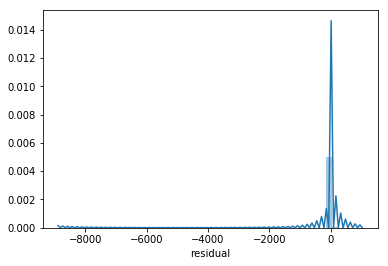

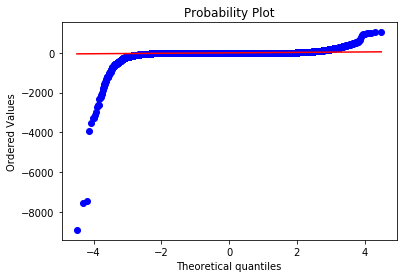

In [69]:
sns.distplot(df['residual']);
fig = plt.figure()
res = stats.probplot(df['residual'], plot=plt)

In [115]:
df = df_bak.copy()
UnitCapVolume_max = df.residual.quantile(0.98, interpolation='lower')
df['OrderNonOutlierResidual'] = np.where(df.residual >= UnitCapVolume_max, UnitCapVolume_max, df.residual)

UnitCapVolume_min = df.residual.quantile(0.02, interpolation='lower')
df['OrderNonOutlierResidual'] = np.where(df.OrderNonOutlierResidual <= UnitCapVolume_min, UnitCapVolume_min, df.OrderNonOutlierResidual)

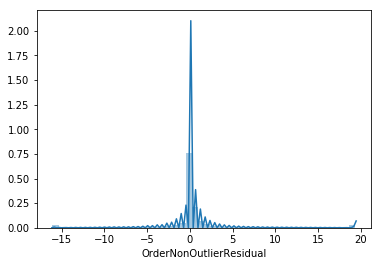

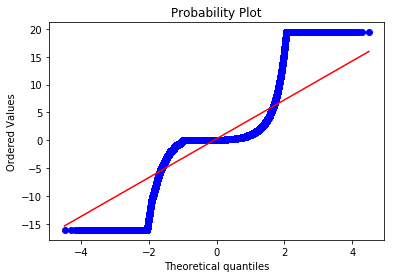

In [116]:
sns.distplot(df['OrderNonOutlierResidual']);
fig = plt.figure()
res = stats.probplot(df['OrderNonOutlierResidual'], plot=plt)

In [90]:
new_list = []
for (dc,sku), group in df.groupby(['RDCKey','ProductKey']):
    # print group.shape
    group['group_num'] = group_num
    new_list.append(group)
new_df = pd.concat(new_list)

/home/ubuntu/lijingjie/ljj/lib/python2.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [93]:
new_df1 = new_df.groupby(['RDCKey','ProductKey','group_num'])['ypred','sales','salesForecast'].sum().reset_index()

In [96]:
new_df1['residual'] = new_df1.ypred - new_df1.salesForecast

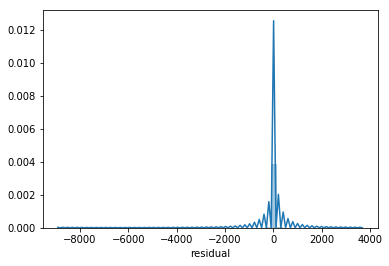

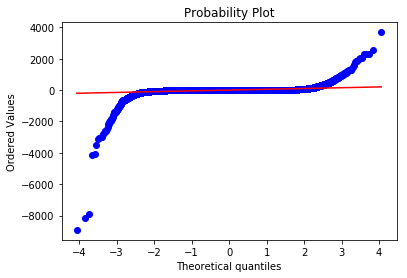

In [97]:
sns.distplot(new_df1['residual']);
fig = plt.figure()
res = stats.probplot(new_df1['residual'], plot=plt)

In [99]:
print new_df1.residual.max()
print new_df1.residual.min()

3685.6806640625
-8915.76904296875


In [117]:
UnitCapVolume_max = new_df1.residual.quantile(0.98, interpolation='lower')
new_df1['OrderNonOutlierResidual'] = np.where(new_df1.residual >= UnitCapVolume_max, UnitCapVolume_max, new_df1.residual)
UnitCapVolume_min = df.residual.quantile(0.02, interpolation='lower')
new_df1['OrderNonOutlierResidual'] = np.where(new_df1.OrderNonOutlierResidual <= UnitCapVolume_min, UnitCapVolume_min, new_df1.OrderNonOutlierResidual)

In [118]:
print new_df1.OrderNonOutlierResidual.max()
print new_df1.OrderNonOutlierResidual.min()

80.57369995117188
-16.085622787475586


In [102]:
print new_df1.residual.quantile(0.98, interpolation='lower')
print new_df1.residual.quantile(0.02, interpolation='lower')

80.5736999512
-70.3481292725


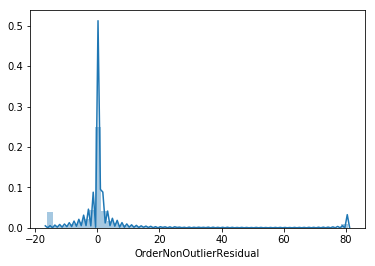

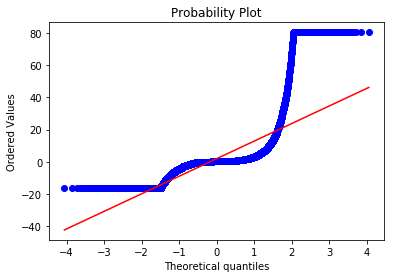

In [119]:
sns.distplot(new_df1['OrderNonOutlierResidual']);
fig = plt.figure()
res = stats.probplot(new_df1['OrderNonOutlierResidual'], plot=plt)

In [78]:
print df.OrderNonOutlierResidual.max()
print df.residual.max()

1020.6484375
1034.6484375


In [198]:
unitVolumeQuantile = raw_train_df.groupby(['RDCKey','ProductKey'])['residual'].quantile(0.02, interpolation='lower')
quantileDf = pd.DataFrame(unitVolumeQuantile).reset_index()
quantileDf.rename(columns = {'residual': 'UnitCapVolume_min'}, inplace=True)
raw_train_df= pd.merge(raw_train_df, quantileDf, how='left', on=['RDCKey','ProductKey'])
raw_train_df['OrderNonOutlierResidual'] = raw_train_df[['residual', 'UnitCapVolume_min']].max(axis=1)

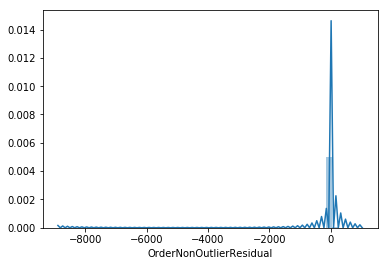

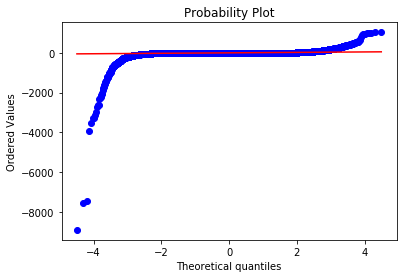

In [199]:
sns.distplot(raw_train_df['OrderNonOutlierResidual']);
fig = plt.figure()
res = stats.probplot(raw_train_df['OrderNonOutlierResidual'], plot=plt)

In [201]:
raw_train_df['OrderNonOutlierResidual'].quantile(1, interpolation='lower')

1034.6484375

In [202]:
df.residual.quantile(0.02, interpolation='lower')

-16.122039318084717

In [ ]:
df_raw = pd.read_csv('736_result_0508_new.csv')

In [181]:
df_raw.head()

,Date,RDCKey,ProductKey,ypred_raw,dd_price_weighted,bd_price_weighted,dd_price_weighted_x,bd_price_weighted_x,SyntheticGrossPrice,ypred_mean_promo,salesForecast
0,2018-05-08,3.0,127768,386.30258,150.279874,150.279874,171.0,171.0,NaN,387.60000,304.0
1,2018-05-09,3.0,127768,386.30258,150.279874,150.279874,171.0,171.0,NaN,387.60000,217.0
2,2018-05-10,3.0,127768,386.30258,150.279874,150.279874,171.0,171.0,NaN,387.60000,29.0
3,2018-05-11,3.0,127768,144.12517,150.279874,150.279874,171.0,171.0,NaN,130.57501,7.0
4,2018-05-12,3.0,127768,164.22660,150.279874,150.279874,171.0,171.0,NaN,151.27571,3.0


In [178]:
print np.sum(np.abs(df_raw.ypred_raw - df_raw.salesForecast)) / np.sum(df_raw.salesForecast)
df1_raw = df_raw.groupby(['RDCKey','ProductKey'])['ypred_raw','salesForecast'].sum().reset_index()
print np.sum(np.abs(df1_raw.ypred_raw - df1_raw.salesForecast)) / np.sum(df1_raw.salesForecast)
df2_raw = df_raw.groupby('ProductKey')['ypred_raw','salesForecast'].sum().reset_index()
print np.sum(np.abs(df2_raw.ypred_raw - df2_raw.salesForecast)) / np.sum(df2_raw.salesForecast)

0.6013378227210685
0.3483888834216435
0.22747504857941325


In [179]:
df1 = df[df.Date<='2018-05-14']
df2 = df1.groupby(['RDCKey','ProductKey']).sum().reset_index()
df3 = df1.groupby('ProductKey').sum().reset_index()
print np.sum(np.abs(df1.ypred - df1.salesForecast)) / np.sum(df1.salesForecast)
print np.sum(np.abs(df2.ypred - df2.salesForecast)) / np.sum(df2.salesForecast)
print np.sum(np.abs(df3.ypred - df3.salesForecast)) / np.sum(df3.salesForecast)

0.6014417668030404
0.3500724962122709
0.22703891854021072


In [180]:
#df1 = df[df.Date<='2018-05-14']
df22 = df.groupby(['RDCKey','ProductKey']).sum().reset_index()
df33 = df.groupby('ProductKey').sum().reset_index()
print np.sum(np.abs(df.ypred - df.salesForecast)) / np.sum(df.salesForecast)
print np.sum(np.abs(df22.ypred - df22.salesForecast)) / np.sum(df22.salesForecast)
print np.sum(np.abs(df33.ypred - df33.salesForecast)) / np.sum(df33.salesForecast)

0.64023945168861
0.2882319993838219
0.21591964098107105


In [189]:
ForecastStartDate = pd.to_datetime(pred_date)
DataStartDate = ForecastStartDate - datetime.timedelta(days=scenario['lookbackPeriodDays'])
PredictEndDate = ForecastStartDate + datetime.timedelta(days=(scenario['lookforwardPeriodDays']-1))

actual = simplified_ts_df
actual.Date = pd.to_datetime(actual.Date)
actual.RDCKey = actual.RDCKey.astype(float)

list_keys = ['Date','RDCKey','ProductKey']
feat_cols = ['dd_price_weighted','bd_price_weighted','dd_price_weighted_x','bd_price_weighted_x','SyntheticGrossPrice']
exclu_promo_features = ['strongmark','flashsale_ind','dd_ind','bundle_ind','bundle_buy199get100_ind','suit_ind','freegift_ind']


In [190]:
def get_raw_test_df(raw_pred, keys, feat_cols):

	raw = raw_pred  ###bottomup forecast
	raw = raw[keys + ['ypred']]
	
	mean_df = mean_pred
	mean_df = mean_df[keys + feat_cols + ['salesForecast','ypred']]
	mean_df.rename(columns={'ypred':'ypred_mean_promo'},inplace=True)
	mean_df.drop('salesForecast',axis=1,inplace=True)

	new_df = raw.merge(mean_df,on=list_keys)
	new_df.Date = pd.to_datetime(new_df.Date)
	new_df = pd.merge(new_df, actual[list_keys+['salesForecast']], how='left',on = list_keys)

	return new_df
new_df = get_raw_test_df(final_result, q_mean_result, list_keys, feat_cols)


/home/ubuntu/lijingjie/ljj/lib/python2.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/ubuntu/lijingjie/ljj/lib/python2.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


In [191]:
new_df.head()

,Date,RDCKey,ProductKey,ypred_raw,dd_price_weighted,bd_price_weighted,dd_price_weighted_x,bd_price_weighted_x,SyntheticGrossPrice,ypred_mean_promo,salesForecast
0,2018-05-08,3.0,127768,386.302582,150.279874,150.279874,171.0,171.0,NaN,387.600006,304.0
1,2018-05-09,3.0,127768,386.302582,150.279874,150.279874,171.0,171.0,NaN,387.600006,217.0
2,2018-05-10,3.0,127768,386.302582,150.279874,150.279874,171.0,171.0,NaN,387.600006,29.0
3,2018-05-11,3.0,127768,144.125168,150.279874,150.279874,171.0,171.0,NaN,130.575012,7.0
4,2018-05-12,3.0,127768,164.226593,150.279874,150.279874,171.0,171.0,NaN,151.275711,3.0


In [192]:
new_df.to_csv('736_result_0508_new.csv',index=False)

sku_dc_new_df = new_df.groupby(['ProductKey','RDCKey'])[['ypred_raw','salesForecast']].sum().reset_index()

print sku_dc_new_df.head()

print np.sum(np.abs(sku_dc_new_df.ypred_raw - sku_dc_new_df.salesForecast))/np.sum(sku_dc_new_df.salesForecast)

sku_dc_new_df.ProductKey.drop_duplicates().shape

sku_dc_new_df['residual'] = sku_dc_new_df.salesForecast - sku_dc_new_df.ypred_raw
sku_dc_new_df['residual_abs'] = np.abs(sku_dc_new_df.salesForecast - sku_dc_new_df.ypred_raw)

sns.distplot(sku_dc_new_df['residual']);
fig = plt.figure()
res = stats.probplot(sku_dc_new_df['residual'], plot=plt)

In [195]:
sku_new_df = new_df.groupby(['ProductKey'])[['ypred_raw','salesForecast']].sum().reset_index()

sku_new_df.head()

print np.sum(np.abs(sku_new_df.ypred_raw - sku_new_df.salesForecast))/np.sum(sku_new_df.salesForecast)

0.22747504830964954


In [196]:
print np.sum(np.abs(new_df.ypred_raw - new_df.salesForecast))/np.sum(new_df.salesForecast)

0.6013378221787343
